In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import math
import os
import datetime
import re
#from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
#drive.mount('/content/drive')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import scipy.stats as stats

In [2]:
freqs = pd.read_csv('./data/frequenciesExtra.csv')

/Users/chrszlr/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (481) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
numberRe = re.compile('[0-9]+')
noneRe = re.compile('None')
def daysStrToInt(dStr):
    if isinstance(dStr, str):
        if numberRe.match(dStr):
            return int(dStr.split(' ')[0])
        elif noneRe.match(dStr):
            return None
    return dStr

freqs['hospDistance'] = freqs['hospDistance'].transform(daysStrToInt)

In [4]:
def deIdCrf(crfs):
  return crfs.drop(columns=['Masked Client ID', 'Date of Review', 'Date'])

def deIdAdl(adls):
  return adls.drop(columns=['DeIdentify ID', 'CaregiverID', 'VisitDate', 'ActualTimeIn', 'ActualTimeOut', 'Date'])

In [6]:
x = deIdAdl(freqs).drop(columns=['hasHospitalization', 'hospDistance'])
y = freqs['hasHospitalization']
d = freqs['hospDistance']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=15)

In [41]:
PCA_O = PCA(n_components=150)
pca_train = PCA_O.fit_transform(x_train)
pca_test = PCA_O.transform(x_test)

In [ ]:
#New column in frequency data
#Has been to hospital before / of all CRFs how many times was hospitalization

In [19]:
#weights = {1.0: 200, 0.0: 1}
weights = {1.0: 1, 0.0: 200}

#model = SVC(kernel='poly', C=10, class_weight='balanced')
#model = SVC(kernel='poly', C=1, degree=3, class_weight='balanced')
#model = SVC(kernel='poly', C=1, degree=3)
#model = SVC(kernel='poly', C=1, degree=3, class_weight=weights)
#model = SVC(kernel='linear', C=10, class_weight='balanced')
#model = SVC(kernel='linear', C=1, class_weight='balanced')
model = SVC(kernel='linear', C=1, class_weight=weights)
#model = SVC(kernel='linear')
#model = DecisionTreeClassifier(criterion='entropy')
#model = KNeighborsClassifier(n_neighbors=5)
#model = BaggingClassifier(base_estimator=SVC(kernel='linear'), n_estimators=10, random_state=15)

model.fit(x_train, y_train)
#model.fit(pca_train, y_train)

SVC(C=1, class_weight={0.0: 200, 1.0: 1}, kernel='linear')

In [20]:
#pred_train = model.predict(pca_train)
#pred_test = model.predict(pca_test)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     41722
         1.0       1.00      0.62      0.77       221

    accuracy                           1.00     41943
   macro avg       1.00      0.81      0.88     41943
weighted avg       1.00      1.00      1.00     41943



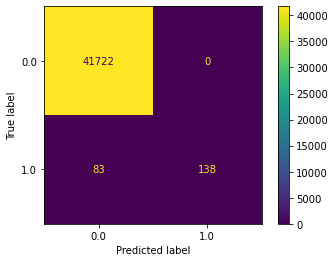

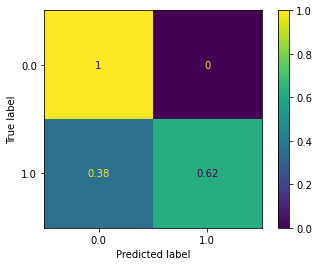

In [14]:
#Training results
plot_confusion_matrix(model, x_train, y_train)
plot_confusion_matrix(model, x_train, y_train, normalize='true')
#plot_confusion_matrix(model, pca_train, y_train)
#plot_confusion_matrix(model, pca_train, y_train, normalize='true')
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13926
         1.0       0.78      0.55      0.65        56

    accuracy                           1.00     13982
   macro avg       0.89      0.78      0.82     13982
weighted avg       1.00      1.00      1.00     13982



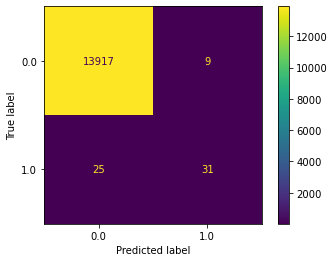

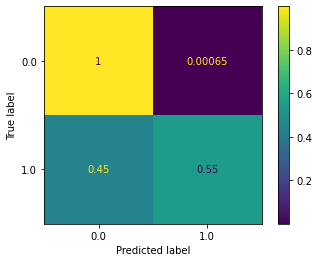

In [15]:
#Test results
plot_confusion_matrix(model, x_test, y_test)
plot_confusion_matrix(model, x_test, y_test, normalize='true')
#plot_confusion_matrix(model, pca_test, y_test)
#plot_confusion_matrix(model, pca_test, y_test, normalize='true')
print(classification_report(y_test, pred_test))

In [21]:
conf_train = confusion_matrix(y_true=y_train, y_pred=pred_train)
conf_test = confusion_matrix(y_true=y_test, y_pred=pred_test)

def calculateScores(conf):
    precision = conf[1,1]/sum(conf[:,1])
    recall = conf[1,1]/sum(conf[1])
    f1Score = 2/(1/precision + 1/recall)
    return precision, recall, f1Score

#Looking for high recall
for i in [conf_train, conf_test]:
    p, r, f = calculateScores(i)
    print(f'Precision: {p}\nRecall: {r}\nF1 Score: {f}\n')

Precision: 1.0
Recall: 0.6244343891402715
F1 Score: 0.7688022284122563

Precision: 0.775
Recall: 0.5535714285714286
F1 Score: 0.6458333333333334



In [24]:
#Only usable for linear kernel
def computeDistance(x_vals, model):
    p = model.decision_function(x_vals)
    w_norm = np.linalg.norm(model.coef_)
    dist = p / w_norm
    dist = p
    return pd.Series(data=dist)

In [30]:
dist_train = computeDistance(x_train, model)
dist_test = computeDistance(x_test, model)
#CHANGE FOR WHICH SET SHOULD BE COMPUTED
dist = dist_test
graphData = []
step = 20
boundary = min(dist)
rng = max(dist)-boundary
for i in range(0,1+step):
    v = boundary+(i/step)*rng
    # nope # eq included so that 0 and 1 are caught
    #print(f'v: {v}, p: {predVal}')
    sub = dist.loc[(dist >= v) & (dist < v+rng/step)]
    a = {'Prob': v, 'Density': len(sub)}
    #print(graphData)
    graphData.append(a)
graphData = pd.DataFrame(data=graphData)
#graphData = graphData.astype(float)

In [120]:
"""
percentile = stats.norm(dist.mean(), dist.std())
g = pd.DataFrame()
g.insert(0, 'x', dist)
g.insert(1, 'y', percentile.cdf(dist))
"""

In [141]:
"""
g = pd.DataFrame()
g.insert(0, 'x', sorted(dist))
pct = []
for i, v in g['x'].items():
    pct.append(i/len(g['x']))
g.insert(1, 'y', pct)
"""

In [31]:
g = pd.DataFrame()
g.insert(0, 'x', dist)
#g.insert(1, 'y', d.iloc[x_train.index])
g.insert(1, 'y', d.iloc[x.index])

<AxesSubplot:xlabel='x', ylabel='y'>

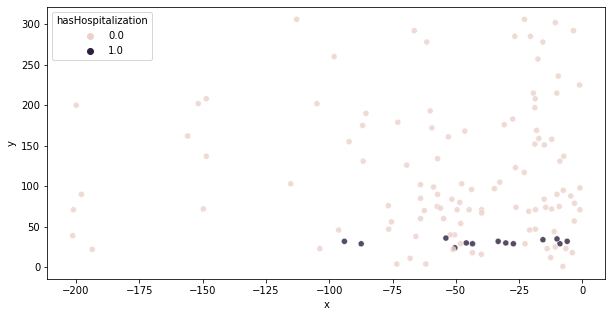

In [34]:
#Graph for true label and distance from SVM border given date until hospitalization
plt.figure(figsize=(10,5))
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=0.8)

<AxesSubplot:xlabel='x', ylabel='y'>

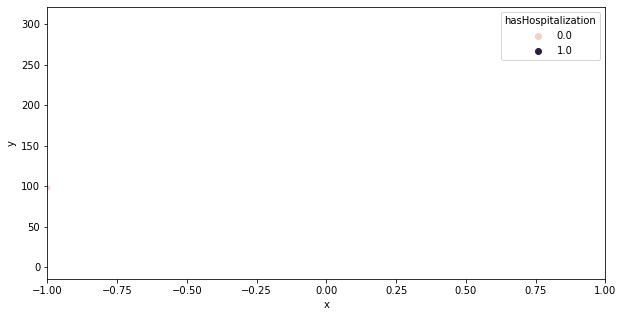

In [36]:
#X-axis limited graph
plt.figure(figsize=(10,5))
plt.xlim(-1, 1)
sns.scatterplot(x='x',y='y',data=g,hue=y_test,alpha=1)